# Tree Datasets

-- Trees reduce urban heat island effects and save lives! 
https://www.epa.gov/green-infrastructure/reduce-urban-heat-island-effect

From: https://www.nature.com/articles/s41597-023-02000-w#Sec8
## Canopy Height Model (CHM)
- Resolution: 1m spatial resolution:
- Values: The final CHM map has values ranging from 20 to 600 dm.
- Data Projection and Format for both CHM and Carbon Density: Both CHM and Carbon Density maps are in GeoTiff format under the NAD83 (National Spatial Reference System 2011) Universal Transverse Mercator Zone 18 North projection.
The CHM dataset was recorded in the unit of decimetre (dm) considering the precision of the LiDAR dataset (approximately 9 cm) and was saved in integer data format. Pixels with CHM values lower than 2 m were considered as non-tree, and masked out along with other non-vegetation land cover types. Pixels with CHM larger than 60 m were also masked out as non-trees to avoid misclassification with buildings since trees larger than 60 m were unlikely to exist in NYC. 

## Carbon density:
- Resolution: 1 m spatial
- Values: 0 - 410.1 ton/ha in floats
- Data Projection and Format: see above

A carbon density map over the tree canopy covered area for the entire NYC at 1 m spatial resolution in the unit of ton/ha. The Carbon density ranged from 0 to 410.1 ton/ha in float data format. 


## Individual Tree Dataset
- Refined polygons segmented from LiDAR-based CHM. 
- individual tree location by borough
- Attributes table of the tree crown polygons include the tree ID, polygon area (m2), tree top height (m), tree mean height (m), tree volume (m3), and carbon storage (predicted value, lower value, and upper value in ton).
- format: shapefiles

## Kernel Density Estimates of Trees

- Calculated in R tidy's st_kde() using the Individual Tree Dataset from above
- Scaled from -1 to 1
- 1 HA resolution

## Canopy Area
- Summarized at 1ha resolution (as a percentage)


# Load Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rioxarray as rxr
import rasterio
from rasterio import plot as rioplot
from rasterio.plot import plotting_extent
import geopandas as gpd

import rasterstats as rs # zonalstatistics function used to extract raster values
import earthpy as et
import earthpy.plot as ep

import uuid


# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

# Load Rasters and Extract by Point
- code reference: https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/



In [2]:
# Load the CHM geotiff
file_name = '../data/greenness/NY_CHM_10Int260m.tif'

chm = rxr.open_rasterio(file_name, masked=True).squeeze()

# carbon density tiff
file_name = '../data/greenness/NY_CHM529_CCset0_Carbondensity.tif'

cd = rxr.open_rasterio(file_name, masked = True).squeeze()

# CD is really zero inflated which will impact zonal stats - set 0 equal to NaN
cd = cd.where(cd != 0, np.nan)

# crown area tiff
file_name = '../data/L1/crown_area_ha.tiff'

ca = rxr.open_rasterio(file_name, masked = True)

# tree density
file_name = '../data/L1/tree_kde_dens_1ha_scaled.tiff'

td = rxr.open_rasterio(file_name, masked = True)

In [3]:
# View summary statistics of canopy height model
print('Mean CHM (dm):', chm.mean().values)
print('Max CHM (dm):', chm.max().values)
print('Min CHM (dm):', chm.min().values)



Mean CHM (dm): 119.80263
Max CHM (dm): 599.0
Min CHM (dm): 21.0


In [4]:
# View summar statistics of the carbon density model
print('Mean Carbon Density:', cd.mean().values)
print('Max Carbon Density:', cd.max().values)
print('Min Carbon Density:', cd.min().values)



Mean Carbon Density: 70.02263
Max Carbon Density: 410.08502197265625
Min Carbon Density: 1.9554377104213927e-06


In [5]:
print('Mean Tree Density:', td.median().values)
print('Max Tree Density:', td.max().values)
print('Min Tree Density:', td.min().values)

type(td)

Mean Tree Density: -0.7818629741668701
Max Tree Density: 1.0
Min Tree Density: -1.0


xarray.core.dataarray.DataArray

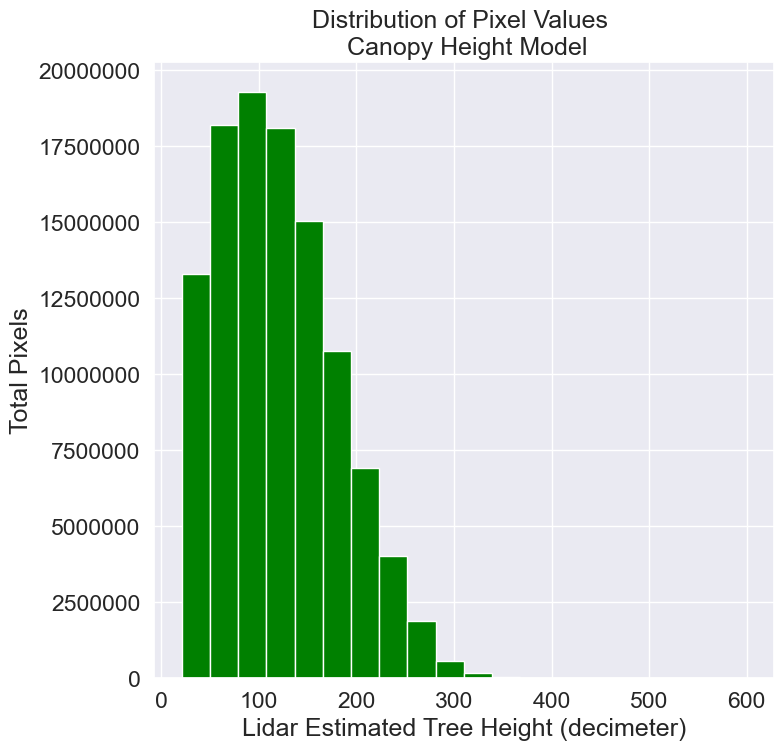

In [6]:
# Plot histrogram of CHM


# Explore the data by plotting a histogram with earthpy
ax = ep.hist(chm.values,
             figsize=(8, 8),
             colors="green",
             xlabel="Lidar Estimated Tree Height (decimeter)",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

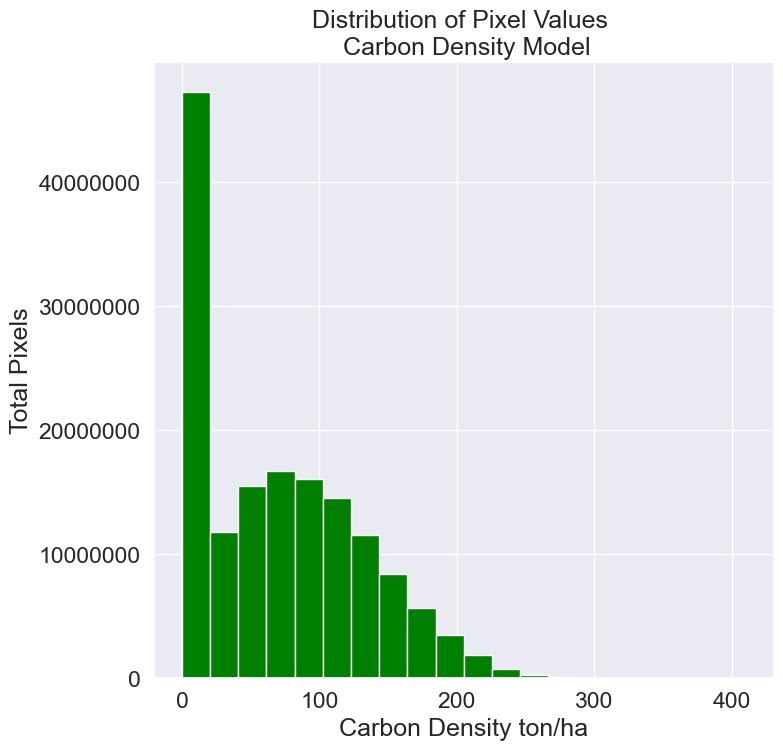

In [7]:
# Plot histrogram of carbon density


# Explore the data by plotting a histogram with earthpy
ax = ep.hist(cd.values,
             figsize=(8, 8),
             colors="green",
             xlabel="Carbon Density ton/ha",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n Carbon Density Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

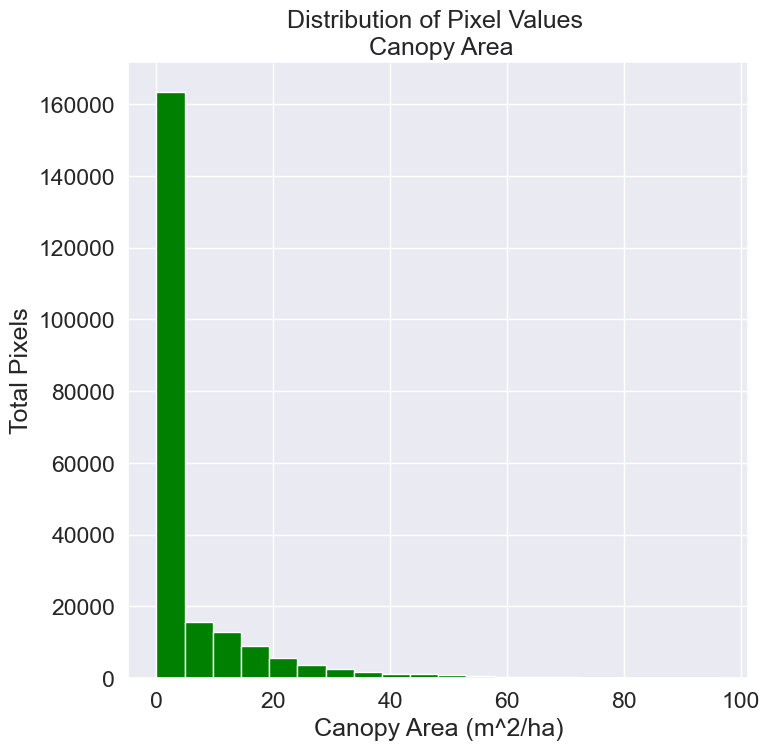

In [8]:
# Plot histrogram of canopy area


# Explore the data by plotting a histogram with earthpy
ax = ep.hist(ca.values,
             figsize=(8, 8),
             colors="green",
             xlabel="Canopy Area (m^2/ha)",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n Canopy Area")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

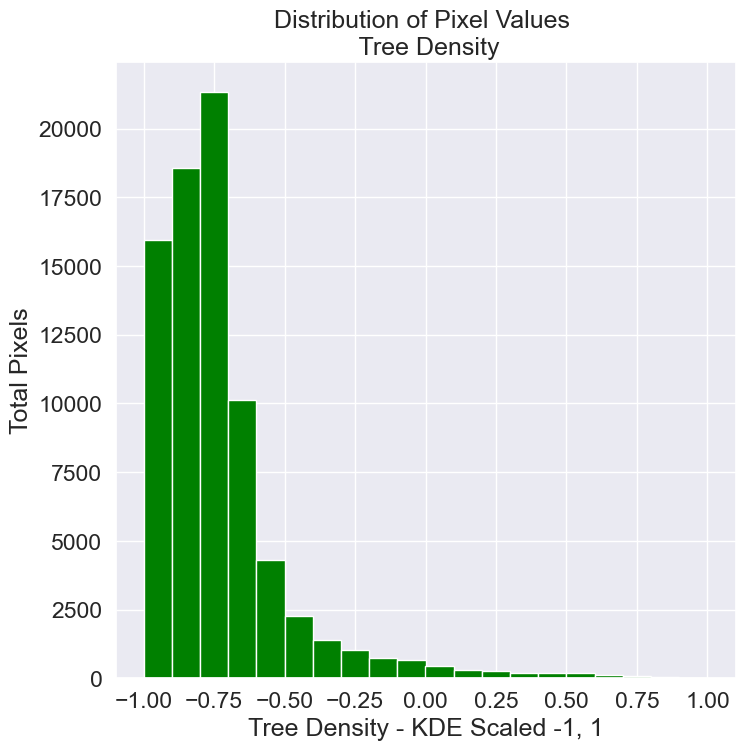

In [9]:
# Plot histrogram of scaled tree density


# Explore the data by plotting a histogram with earthpy
ax = ep.hist(td.values,
             figsize=(8, 8),
             colors="green",
             xlabel="Tree Density - KDE Scaled -1, 1",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n Tree Density")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

In [10]:
# Load in affordable housing subsidy dataset as output from 01
subsidies = pd.read_csv('../data/L1/subsidies.csv')
print(subsidies.columns)
# drop unnamed: 0
subsidies = subsidies.drop(labels = 'Unnamed: 0', axis = 1)
subsidies["Value Per Unit"] = subsidies['assessed_value'] / subsidies['res_units']


Index(['Unnamed: 0', 'bbl', 'subsidy_program', 'end_date', 'standard_address',
       'city_id', 'city_name', 'boro_id', 'boro_name', 'cd_id', 'cd_name',
       'sba_id', 'sba_name', 'ccd_id', 'ccd_name', 'tract_10', 'res_units',
       'year_built', 'buildings', 'assessed_value', 'owner_name',
       'ser_violation', 'tax_delinquency', 'latitude', 'longitude',
       'subsidy_program_full', 'URL', 'Supply_Demand', 'Category', 'Scale',
       'Timeframe', 'Occupancy Tenure', 'Construction Type',
       'Max Income Restriction(%AMI)', 'Occupancy Demographic',
       'Income Designation', 'Project Eligibility', 'Developers/Owners',
       'geometry'],
      dtype='object')


In [11]:


subsidies["loc"] = subsidies['standard_address'] + ' ' + subsidies["city_name"]

subsidies = (subsidies[["loc", "bbl", "subsidy_program_full", "Value Per Unit", 
                        "boro_name", "latitude", "longitude", "Max Income Restriction(%AMI)",
                       "Occupancy Demographic", "Income Designation", 'URL']])


np.unique(subsidies['subsidy_program_full'])
subsidies


loc         bbl  \
0               80 Rutgers Slip New York City  1002480070   
1               80 Rutgers Slip New York City  1002480070   
2               80 Rutgers Slip New York City  1002480070   
3          15 Bialystoker Place New York City  1003360005   
4          15 Bialystoker Place New York City  1003360005   
...                                       ...         ...   
14045            Seaview Avenue New York City  3044520090   
14046       186 Vandalia Avenue New York City  3044520105   
14047     155 Schroeders Avenue New York City  3044520125   
14048  1279 Pennsylvania Avenue New York City  3044520135   
14049         Van Siclen Avenue New York City  3044520151   

              subsidy_program_full  Value Per Unit  boro_name   latitude  \
0                    Section 202/8    51766.513761  Manhattan  40.710802   
1      420-c Tax Incentive Program    51766.513761  Manhattan  40.710802   
2                         LIHTC 4%    51766.513761  Manhattan  40.710802   
3                    Section 202/8    68058.984375  Manhattan  40.715819   
4                         LIHTC 4%    68058.984375  Manhattan  40.715819   
...                            ...             ...        ...        ...   
14045      Project-Based Section 8             NaN   Brooklyn  40.642363   
14046      Project-Based Section 8             NaN   Brooklyn  40.651641   
14047      Project-Based Section 8             NaN   Brooklyn  40.649082   
14048      Project-Based Section 8             NaN   Brooklyn  40.649721   
14049      Project-Based Section 8             NaN   Brooklyn  40.645975   

       longitude Max Income Restriction(%AMI)  \
0     -73.990193                           50   
1     -73.990193                           60   
2     -73.990193                           60   
3     -73.983302                           50   
4     -73.983302                           60   
...          ...                          ...   
14045 -73.878031                           80   
14046 -73.881827                           80   
14047 -73.880263                           80   
14048 -73.882792                           80   
14049 -73.875170                           80   

                               Occupancy Demographic  \
0                 Seniors; Persons with Disabilities   
1      Homeless; Persons with Disabilities; Families   
2                                       All Eligable   
3                 Seniors; Persons with Disabilities   
4                                       All Eligable   
...                                              ...   
14045                                   All Eligable   
14046                                   All Eligable   
14047                                   All Eligable   
14048                                   All Eligable   
14049                                   All Eligable   

                Income Designation  \
0                  Very Low-income   
1                       Low-income   
2      Very Low-income, Low-income   
3                  Very Low-income   
4      Very Low-income, Low-income   
...                            ...   
14045            Extremely-low:Low   
14046            Extremely-low:Low   
14047            Extremely-low:Low   
14048            Extremely-low:Low   
14049            Extremely-low:Low   

                                                     URL  
0      https://furmancenter.org/coredata/directory/en...  
1      https://furmancenter.org/coredata/directory/en...  
2      https://furmancenter.org/coredata/directory/en...  
3      https://furmancenter.org/coredata/directory/en...  
4      https://furmancenter.org/coredata/directory/en...  
...                                                  ...  
14045  https://furmancenter.org/coredata/directory/en...  
14046  https://furmancenter.org/coredata/directory/en...  
14047  https://furmancenter.org/coredata/directory/en...  
14048  https://furmancenter.org/coredata/directory/en...  
14049  https://furmancenter.

In [12]:
rentstab = pd.read_csv('../data/L1/rent_stabilized_clean.csv')

# create unique id as bbl for rentstab
rentstab['bbl'] = [str(uuid.uuid4()) for _ in range(len(rentstab.index))]
rentstab['URL'] = 'https://rentguidelinesboard.cityofnewyork.us/resources/faqs/rent-control/'

subsidies['bbl'] = subsidies['bbl'].astype(str).str.rstrip(".0")


x = pd.concat([subsidies, rentstab])

x


loc  \
0                          80 Rutgers Slip New York City   
1                          80 Rutgers Slip New York City   
2                          80 Rutgers Slip New York City   
3                     15 Bialystoker Place New York City   
4                     15 Bialystoker Place New York City   
...                                                  ...   
27949      105 Freedom Ave, Staten Island, NY 10314, USA   
27950    155 Friendship Ln, Staten Island, NY 10314, USA   
27951    1290 Richmond Ave, Staten Island, NY 10314, USA   
27952    1300 Richmond Ave, Staten Island, NY 10314, USA   
27953  1000 Willowbrook Rd, Staten Island, NY 10314, USA   

                                        bbl         subsidy_program_full  \
0                                 100248007                Section 202/8   
1                                 100248007  420-c Tax Incentive Program   
2                                 100248007                     LIHTC 4%   
3                                1003360005                Section 202/8   
4                                1003360005                     LIHTC 4%   
...                                     ...                          ...   
27949  4c1fb15a-968c-45f6-ae1e-a83f38007bd0           Rent Stabilization   
27950  571e77da-2ba1-45f7-8dae-ef4f687e012d           Rent Stabilization   
27951  ec0b9b09-856d-42c8-8fa8-3fb226e9a4cc           Rent Stabilization   
27952  8036f280-c1ac-4ca3-a736-539390001225           Rent Stabilization   
27953  fd77e618-6b54-43bf-9681-7ef77a9e4e61           Rent Stabilization   

       Value Per Unit      boro_name   latitude  longitude  \
0        51766.513761      Manhattan  40.710802 -73.990193   
1        51766.513761      Manhattan  40.710802 -73.990193   
2        51766.513761      Manhattan  40.710802 -73.990193   
3        68058.984375      Manhattan  40.715819 -73.983302   
4        68058.984375      Manhattan  40.715819 -73.983302   
...               ...            ...        ...        ...   
27949             NaN  Staten Island  40.596983 -74.163235   
27950             NaN  Staten Island  40.595997 -74.130925   
27951             NaN  Staten Island  40.617208 -74.157252   
27952             NaN  Staten Island  40.616942 -74.156797   
27953             NaN  Staten Island  40.602640 -74.139559   

      Max Income Restriction(%AMI)  \
0                               50   
1                               60   
2                               60   
3                               50   
4                               60   
...                            ...   
27949              No Restrictions   
27950              No Restrictions   
27951              No Restrictions   
27952              No Restrictions   
27953              No Restrictions   

                               Occupancy Demographic  \
0                 Seniors; Persons with Disabilities   
1      Homeless; Persons with Disabilities; Families   
2                                       All Eligable   
3                 Seniors; Persons with Disabilities   
4                                       All Eligable   
...                                              ...   
27949                                   All Eligable   
27950                                   All Eligable   
27951                                   All Eligable   
27952                                   All Eligable   
27953                                   All Eligable   

                Income Designation  \
0                  Very Low-income   
1                       Low-income   
2      Very Low-income, Low-income   
3                  Very Low-income   
4      Very Low-income, Low-income   
...                            ...   
27949              No Restrictions   
27950              No Restrictions   
27951              No Restrictions   
27952              No Restrictions   
27953              No Restrictions   

                                                     URL  
0      https://furmancenter.

In [13]:
# We want to get rid of duplicate BBLs for processing efficiency but the rent stabilized dataset does not list BBLs...
# To resolve this, we will assign the unique row_id as the 'bbl' where bbl is na

# use fillna() to replace null values in column2 with values from column1
x_nodupes = x.copy()


x_nodupes = x_nodupes.drop_duplicates(subset="bbl")

print("No. records dropped in deduplication = " + str(len(x) - len(x_nodupes)))

x_nodupes.columns

No. records dropped in deduplication = 2512


Index(['loc', 'bbl', 'subsidy_program_full', 'Value Per Unit', 'boro_name',
       'latitude', 'longitude', 'Max Income Restriction(%AMI)',
       'Occupancy Demographic', 'Income Designation', 'URL'],
      dtype='object')

In [14]:
x['bbl'].nunique() == x_nodupes['bbl'].nunique() == len(x_nodupes)

True

In [15]:
# Convert to spatial points
points = gpd.GeoDataFrame(x_nodupes, geometry = gpd.points_from_xy(x_nodupes['longitude'], x_nodupes['latitude']), 
                                 crs = 4326)


type(points)

# Convert to the same projection as the canopy height and carbon density models: 
# NAD83 (National Spatial Reference System 2011) Universal Transverse Mercator Zone 18 North projection
# ESPG: https://epsg.io/6347 - 6347

points.to_crs(crs = 6347, inplace = True)
points


loc  \
0                          80 Rutgers Slip New York City   
3                     15 Bialystoker Place New York City   
5                        69 West 88 Street New York City   
8                        234 East 2 Street New York City   
11                       538 East 6 Street New York City   
...                                                  ...   
27949      105 Freedom Ave, Staten Island, NY 10314, USA   
27950    155 Friendship Ln, Staten Island, NY 10314, USA   
27951    1290 Richmond Ave, Staten Island, NY 10314, USA   
27952    1300 Richmond Ave, Staten Island, NY 10314, USA   
27953  1000 Willowbrook Rd, Staten Island, NY 10314, USA   

                                        bbl subsidy_program_full  \
0                                 100248007        Section 202/8   
3                                1003360005        Section 202/8   
5                                1012020001        Section 202/8   
8                                1003850053        Section 202/8   
11                               1004010029        Section 202/8   
...                                     ...                  ...   
27949  4c1fb15a-968c-45f6-ae1e-a83f38007bd0   Rent Stabilization   
27950  571e77da-2ba1-45f7-8dae-ef4f687e012d   Rent Stabilization   
27951  ec0b9b09-856d-42c8-8fa8-3fb226e9a4cc   Rent Stabilization   
27952  8036f280-c1ac-4ca3-a736-539390001225   Rent Stabilization   
27953  fd77e618-6b54-43bf-9681-7ef77a9e4e61   Rent Stabilization   

       Value Per Unit      boro_name   latitude  longitude  \
0        51766.513761      Manhattan  40.710802 -73.990193   
3        68058.984375      Manhattan  40.715819 -73.983302   
5        69558.284024      Manhattan  40.787934 -73.970605   
8        48930.000000      Manhattan  40.721706 -73.982095   
11       40050.000000      Manhattan  40.724525 -73.982304   
...               ...            ...        ...        ...   
27949             NaN  Staten Island  40.596983 -74.163235   
27950             NaN  Staten Island  40.595997 -74.130925   
27951             NaN  Staten Island  40.617208 -74.157252   
27952             NaN  Staten Island  40.616942 -74.156797   
27953             NaN  Staten Island  40.602640 -74.139559   

      Max Income Restriction(%AMI)               Occupancy Demographic  \
0                               50  Seniors; Persons with Disabilities   
3                               50  Seniors; Persons with Disabilities   
5                               50  Seniors; Persons with Disabilities   
8                               50  Seniors; Persons with Disabilities   
11                              50  Seniors; Persons with Disabilities   
...                            ...                                 ...   
27949              No Restrictions                        All Eligable   
27950              No Restrictions                        All Eligable   
27951              No Restrictions                        All Eligable   
27952              No Restrictions                        All Eligable   
27953              No Restrictions                        All Eligable   

      Income Designation                                                URL  \
0        Very Low-income  https://furmancenter.org/coredata/directory/en...   
3        Very Low-income  https://furmancenter.org/coredata/directory/en...   
5        Very Low-income  https://furmancenter.org/coredata/directory/en...   
8        Very Low-income  https://furmancenter.org/coredata/directory/en...   
11       Very Low-income  https://furmancenter.org/coredata/directory/en...   
...                  ...                                                ...   
27949    No Restrictions  https://rentguidelinesboard.cityofnewyork.us/r...   
27950    No Restrictions  https://rentguidelinesboard.cityofnewyork.us/r...   
27951    No Restrictions  https://rentguidelinesboard.cityofnewyork.us/r...   
27952    No Restrictions  https://rentguidelinesboard.cityofnewyork.us/r...   
27953    No 

## Extract raster values of tree density and canopy area


### Extract pixel values of CHM for affordable housing location

In [16]:
# Extract values from the tree density raster to the points
vals = []
for point in points['geometry']:
    x1 = point.xy[0][0]
    y = point.xy[1][0]
    vals.append(td.sel(x=x1,y=y, method = 'nearest').values.item())

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future vers

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Ind

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future vers

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future vers

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future vers

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
len(vals) == len(points)

True

In [18]:
# Add to the points geopandas dataframe
points['Tree Density (normalized)'] = pd.Series(vals)

In [19]:
# Extract values from the canopy area raster to the points
vals = []
for point in points['geometry']:
    x1 = point.xy[0][0]
    y = point.xy[1][0]
    vals.append(ca.sel(x=x1,y=y, method = 'nearest').values.item())

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future vers

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Ind

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future vers

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future vers

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Ind

In [20]:
len(vals) == len(points)

True

In [21]:
# Add to the points geopandas dataframe
points['Canopy Cover'] = pd.Series(vals)

In [22]:
points.head()

loc         bbl subsidy_program_full  \
0        80 Rutgers Slip New York City   100248007        Section 202/8   
3   15 Bialystoker Place New York City  1003360005        Section 202/8   
5      69 West 88 Street New York City  1012020001        Section 202/8   
8      234 East 2 Street New York City  1003850053        Section 202/8   
11     538 East 6 Street New York City  1004010029        Section 202/8   

    Value Per Unit  boro_name   latitude  longitude  \
0     51766.513761  Manhattan  40.710802 -73.990193   
3     68058.984375  Manhattan  40.715819 -73.983302   
5     69558.284024  Manhattan  40.787934 -73.970605   
8     48930.000000  Manhattan  40.721706 -73.982095   
11    40050.000000  Manhattan  40.724525 -73.982304   

   Max Income Restriction(%AMI)               Occupancy Demographic  \
0                            50  Seniors; Persons with Disabilities   
3                            50  Seniors; Persons with Disabilities   
5                            50  Seniors; Persons with Disabilities   
8                            50  Seniors; Persons with Disabilities   
11                           50  Seniors; Persons with Disabilities   

   Income Designation                                                URL  \
0     Very Low-income  https://furmancenter.org/coredata/directory/en...   
3     Very Low-income  https://furmancenter.org/coredata/directory/en...   
5     Very Low-income  https://furmancenter.org/coredata/directory/en...   
8     Very Low-income  https://furmancenter.org/coredata/directory/en...   
11    Very Low-income  https://furmancenter.org/coredata/directory/en...   

                          geometry  Tree Density (normalized)  Canopy Cover  
0   POINT (585297.142 4507144.438)                  -0.765969         16.04  
3   POINT (585872.753 4507708.039)                  -0.657094         21.35  
5   POINT (586851.300 4515725.907)                  -0.665983         12.55  
8   POINT (585967.084 4508362.749)                  -0.618753         17.73  
11  POINT (585945.848 4508675.462)                  -0.706788         27.00

## Create buffer zones of ~56m radius around each affordable housing location
- this will compare the 
- We will use zonal statistics to measure min, mean, max, median for carbon density and canopy height as these rasters are at the 1m spatial resolution (the canopy area and tree density were at the 1hectare or 10,000m^2 resolution

In [23]:
# Create a buffered polygon layer from your plot location points
buffer = points.copy()[['geometry', 'bbl']]

# Buffer each point using a 20 meter circle radius
# and replace the point geometry with the new buffered geometry
buffer["geometry"] = points.geometry.buffer(56.4)

# If the dir does not exist, create it
output_path = os.path.join("../data/L1/", 
                           "outputs")

if not os.path.isdir(output_path):
    os.mkdir(output_path)

# Export the buffered point layer as a shapefile to use in zonal stats
plot_buffer_path = os.path.join(output_path, 
                                "plot_buffer.shp")

buffer.to_file(plot_buffer_path)

### Extract pixel values of Canopy Height Model for each buffer zone (identified by unique loc)

In [24]:
# Extract zonal stats from chm
extracted_chm = rs.zonal_stats(plot_buffer_path,
                                   chm.values,
                                   affine=chm.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="min mean max median")

# View object type
type(extracted_chm)

/Users/eihwood/opt/anaconda3/lib/python3.9/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


list

In [25]:
# Turn extracted data into a pandas geodataframe
chm_df = gpd.GeoDataFrame.from_features(extracted_chm)



chm_df = chm_df.rename(columns = {"min": "chm_min",
                      "max": "chm_max",
                      "mean": "chm_mean",
                      "median": "chm_median"})

### Extract pixel values of Carbon Density for each buffer zone (identified by unique loc)


In [26]:
# Extract zonal stats from carbon density
extracted_cd = rs.zonal_stats(plot_buffer_path,
                                   cd.values,
                                   affine=cd.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="min mean max median")



In [27]:
# Turn extracted data into a pandas geodataframe
cd_df = gpd.GeoDataFrame.from_features(extracted_cd)



cd_df = cd_df.rename(columns = {"min": "cd_min",
                      "max": "cd_max",
                      "mean": "cd_mean",
                      "median": "cd_median"})



In [28]:
cd_df['bbl'].nunique() == len(cd_df) == points['bbl'].nunique()
cd_df = cd_df.drop('geometry', axis=1)

In [29]:
# merge (default is inner)

df_merge = pd.merge(chm_df, cd_df, on = 'bbl')

df_merge.head()
print(cd_df['bbl'].nunique() == len(cd_df) == points['bbl'].nunique() == df_merge['bbl'].nunique() == len(df_merge))

len(df_merge) == len(chm_df) == len(cd_df)

True


True

In [30]:
df_merge.head()

geometry         bbl  chm_min  \
0  POLYGON ((585353.542 4507144.438, 585353.270 4...   100248007     21.0   
1  POLYGON ((585929.153 4507708.039, 585928.882 4...  1003360005     21.0   
2  POLYGON ((586907.700 4515725.907, 586907.428 4...  1012020001     21.0   
3  POLYGON ((586023.484 4508362.749, 586023.212 4...  1003850053     21.0   
4  POLYGON ((586002.248 4508675.462, 586001.977 4...  1004010029     21.0   

   chm_max    chm_mean  chm_median    cd_min      cd_max    cd_mean  \
0    291.0  134.764170       146.0  0.044609  239.118332  90.908876   
1    318.0  112.407407       113.0  0.020505  261.449127  76.131788   
2    347.0  104.253299        98.0  0.027345  284.721985  55.348239   
3    242.0   94.461009        92.0  0.012957  198.564743  67.197187   
4    237.0  118.431214       121.0  0.005765  194.421280  73.600179   

    cd_median  
0  106.167206  
1   83.310913  
2   50.131321  
3   64.506371  
4   65.462013

In [31]:
# Merge back with points data based on bbl

tree_data_nodupes = pd.merge(points, df_merge, on = 'bbl')

In [32]:
tree_data_nodupes.head()

loc         bbl subsidy_program_full  \
0       80 Rutgers Slip New York City   100248007        Section 202/8   
1  15 Bialystoker Place New York City  1003360005        Section 202/8   
2     69 West 88 Street New York City  1012020001        Section 202/8   
3     234 East 2 Street New York City  1003850053        Section 202/8   
4     538 East 6 Street New York City  1004010029        Section 202/8   

   Value Per Unit  boro_name   latitude  longitude  \
0    51766.513761  Manhattan  40.710802 -73.990193   
1    68058.984375  Manhattan  40.715819 -73.983302   
2    69558.284024  Manhattan  40.787934 -73.970605   
3    48930.000000  Manhattan  40.721706 -73.982095   
4    40050.000000  Manhattan  40.724525 -73.982304   

  Max Income Restriction(%AMI)               Occupancy Demographic  \
0                           50  Seniors; Persons with Disabilities   
1                           50  Seniors; Persons with Disabilities   
2                           50  Seniors; Persons with Disabilities   
3                           50  Seniors; Persons with Disabilities   
4                           50  Seniors; Persons with Disabilities   

  Income Designation  ... Canopy Cover  \
0    Very Low-income  ...        16.04   
1    Very Low-income  ...        21.35   
2    Very Low-income  ...        12.55   
3    Very Low-income  ...        17.73   
4    Very Low-income  ...        27.00   

                                          geometry_y  chm_min  chm_max  \
0  POLYGON ((585353.542 4507144.438, 585353.270 4...     21.0    291.0   
1  POLYGON ((585929.153 4507708.039, 585928.882 4...     21.0    318.0   
2  POLYGON ((586907.700 4515725.907, 586907.428 4...     21.0    347.0   
3  POLYGON ((586023.484 4508362.749, 586023.212 4...     21.0    242.0   
4  POLYGON ((586002.248 4508675.462, 586001.977 4...     21.0    237.0   

     chm_mean  chm_median    cd_min      cd_max    cd_mean   cd_median  
0  134.764170       146.0  0.044609  239.118332  90.908876  106.167206  
1  112.407407       113.0  0.020505  261.449127  76.131788   83.310913  
2  104.253299        98.0  0.027345  284.721985  55.348239   50.131321  
3   94.461009        92.0  0.012957  198.564743  67.197187   64.506371  
4  118.431214       121.0  0.005765  194.421280  73.600179   65.462013  

[5 rows x 23 columns]

In [33]:
len(points)
len(df_merge)
points['bbl'].nunique() == df_merge['bbl'].nunique()
print(tree_data_nodupes['bbl'].nunique())
print(df_merge['bbl'].nunique())
print(len(tree_data_nodupes))
print(len(points))


39492
39492
39492
39492


In [34]:
tree_data_nodupes.drop(['geometry_x', 'geometry_y'], axis = 1, inplace = True)

In [35]:
x_bbl = x['bbl']

In [36]:
# merge back with full data frame (x)


final = pd.merge(x_bbl, tree_data_nodupes, on = "bbl", how = "left")

In [37]:
len(final) == len(x)

True

In [38]:
final.head()

bbl                                 loc subsidy_program_full  \
0   100248007       80 Rutgers Slip New York City        Section 202/8   
1   100248007       80 Rutgers Slip New York City        Section 202/8   
2   100248007       80 Rutgers Slip New York City        Section 202/8   
3  1003360005  15 Bialystoker Place New York City        Section 202/8   
4  1003360005  15 Bialystoker Place New York City        Section 202/8   

   Value Per Unit  boro_name   latitude  longitude  \
0    51766.513761  Manhattan  40.710802 -73.990193   
1    51766.513761  Manhattan  40.710802 -73.990193   
2    51766.513761  Manhattan  40.710802 -73.990193   
3    68058.984375  Manhattan  40.715819 -73.983302   
4    68058.984375  Manhattan  40.715819 -73.983302   

  Max Income Restriction(%AMI)               Occupancy Demographic  \
0                           50  Seniors; Persons with Disabilities   
1                           50  Seniors; Persons with Disabilities   
2                           50  Seniors; Persons with Disabilities   
3                           50  Seniors; Persons with Disabilities   
4                           50  Seniors; Persons with Disabilities   

  Income Designation  ... Tree Density (normalized)  Canopy Cover  chm_min  \
0    Very Low-income  ...                 -0.765969         16.04     21.0   
1    Very Low-income  ...                 -0.765969         16.04     21.0   
2    Very Low-income  ...                 -0.765969         16.04     21.0   
3    Very Low-income  ...                 -0.657094         21.35     21.0   
4    Very Low-income  ...                 -0.657094         21.35     21.0   

   chm_max    chm_mean  chm_median    cd_min      cd_max    cd_mean  \
0    291.0  134.764170       146.0  0.044609  239.118332  90.908876   
1    291.0  134.764170       146.0  0.044609  239.118332  90.908876   
2    291.0  134.764170       146.0  0.044609  239.118332  90.908876   
3    318.0  112.407407       113.0  0.020505  261.449127  76.131788   
4    318.0  112.407407       113.0  0.020505  261.449127  76.131788   

    cd_median  
0  106.167206  
1  106.167206  
2  106.167206  
3   83.310913  
4   83.310913  

[5 rows x 21 columns]

In [39]:
final.bbl.nunique() == tree_data_nodupes.bbl.nunique()

True

In [40]:
# write out 
final.to_csv("../data/L1/affordable_housing_with_tree_data.csv")
tree_data_nodupes.to_csv("../data/L1/affordable_housing_with_tree_data_nodupes.csv")